
## Clean 2D Logistic Regression Example for the Book Figures

This section reproduces a minimal and well-documented 2D example used in the book to illustrate:

- the failure of **linear** logistic regression on a nonlinearly separable dataset, and  
- the success of a **quadratic-feature** logistic regression on the same data.

It also saves two figures into the `figs/` directory:

- `figs/2D-lin-regr.png` – linear logistic regression decision boundary  
- `figs/2D-nonlin-regr.png` – quadratic logistic regression decision boundary


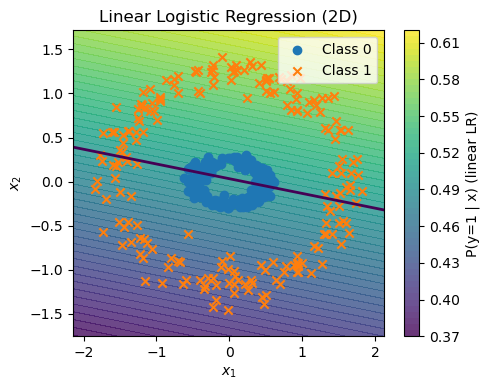

Saved linear logistic regression figure to: figs/2D-lin-regr.png


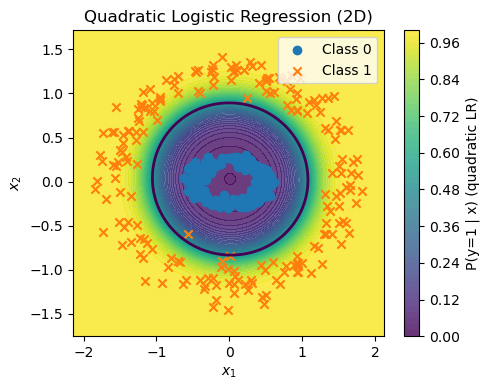

Saved quadratic logistic regression figure to: figs/2D-nonlin-regr.png


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

# -----------------------------------------------------------------------------
# 1. Utility: ensure the output directory for figures exists
# -----------------------------------------------------------------------------

os.makedirs("figs", exist_ok=True)

# -----------------------------------------------------------------------------
# 2. Generate a synthetic 2D dataset with two classes forming a nonlinear pattern
#    Here we use a "two-ellipses" style pattern: one class is near the origin,
#    the other is an outer ring. This mimics the idea of a nonlinear separation.
# -----------------------------------------------------------------------------

rng = np.random.default_rng(0)

n_inner = 200   # number of points in inner cluster
n_outer = 200   # number of points in outer ring

# Inner cluster (class 0)
r_inner = 0.5 * rng.normal(loc=1.0, scale=0.15, size=n_inner)
theta_inner = 2.0 * np.pi * rng.random(n_inner)
x_inner = np.column_stack([r_inner * np.cos(theta_inner),
                           0.5 * r_inner * np.sin(theta_inner)])

# Outer ring (class 1)
r_outer = 1.6 * rng.normal(loc=1.0, scale=0.10, size=n_outer)
theta_outer = 2.0 * np.pi * rng.random(n_outer)
x_outer = np.column_stack([r_outer * np.cos(theta_outer),
                           0.75 * r_outer * np.sin(theta_outer)])

X = np.vstack([x_inner, x_outer])
y = np.concatenate([np.zeros(n_inner, dtype=int),
                    np.ones(n_outer, dtype=int)])

# -----------------------------------------------------------------------------
# 3. Helper to create a grid over the 2D domain for plotting decision boundaries
# -----------------------------------------------------------------------------

def make_grid(X, n_points=300):
    # Create a regular 2D grid covering the convex hull of the data X.
    x_min, x_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3
    y_min, y_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, n_points),
        np.linspace(y_min, y_max, n_points),
    )
    return xx, yy

xx, yy = make_grid(X)

# -----------------------------------------------------------------------------
# 4. Train a standard (linear) logistic regression model
# -----------------------------------------------------------------------------

logreg_lin = LogisticRegression()
logreg_lin.fit(X, y)

# Evaluate model on the grid
grid_points = np.column_stack([xx.ravel(), yy.ravel()])
probs_lin = logreg_lin.predict_proba(grid_points)[:, 1]
probs_lin = probs_lin.reshape(xx.shape)

# -----------------------------------------------------------------------------
# 5. Plot the linear logistic regression decision boundary
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(5, 4))

# Decision regions as filled contour
cs = ax.contourf(xx, yy, probs_lin, levels=50, alpha=0.8)
fig.colorbar(cs, ax=ax, label="P(y=1 | x) (linear LR)")

# Training data
ax.scatter(X[y == 0, 0], X[y == 0, 1], marker="o", label="Class 0")
ax.scatter(X[y == 1, 0], X[y == 1, 1], marker="x", label="Class 1")

# Decision boundary at p=0.5
ax.contour(xx, yy, probs_lin, levels=[0.5], linewidths=2)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Linear Logistic Regression (2D)")
ax.legend(loc="upper right")

fig.tight_layout()
lin_fig_path = "figs/2D-lin-regr.png"
fig.savefig(lin_fig_path, dpi=200)
plt.show()
print(f"Saved linear logistic regression figure to: {lin_fig_path}")

# -----------------------------------------------------------------------------
# 6. Train a logistic regression model with quadratic features
# -----------------------------------------------------------------------------

# PolynomialFeatures with degree=2 produces (1, x1, x2, x1^2, x1 x2, x2^2)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_quad = poly.fit_transform(X)

logreg_quad = LogisticRegression(max_iter=1000)
logreg_quad.fit(X_quad, y)

# Evaluate quadratic model on the grid
grid_quad = poly.transform(grid_points)
probs_quad = logreg_quad.predict_proba(grid_quad)[:, 1]
probs_quad = probs_quad.reshape(xx.shape)

# -----------------------------------------------------------------------------
# 7. Plot the quadratic logistic regression decision boundary
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(5, 4))

cs = ax.contourf(xx, yy, probs_quad, levels=50, alpha=0.8)
fig.colorbar(cs, ax=ax, label="P(y=1 | x) (quadratic LR)")

ax.scatter(X[y == 0, 0], X[y == 0, 1], marker="o", label="Class 0")
ax.scatter(X[y == 1, 0], X[y == 1, 1], marker="x", label="Class 1")

ax.contour(xx, yy, probs_quad, levels=[0.5], linewidths=2)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Quadratic Logistic Regression (2D)")
ax.legend(loc="upper right")

fig.tight_layout()
quad_fig_path = "figs/2D-nonlin-regr.png"
fig.savefig(quad_fig_path, dpi=200)
plt.show()
print(f"Saved quadratic logistic regression figure to: {quad_fig_path}")


## Below is an older version of the notebook

Case 1 (Large Gap): w1 = 38.1461, w2 = 4.6407, b = -1.4559
Case 2 (Small Gap): w1 = 30.8957, w2 = -4.4212, b = 1.5067


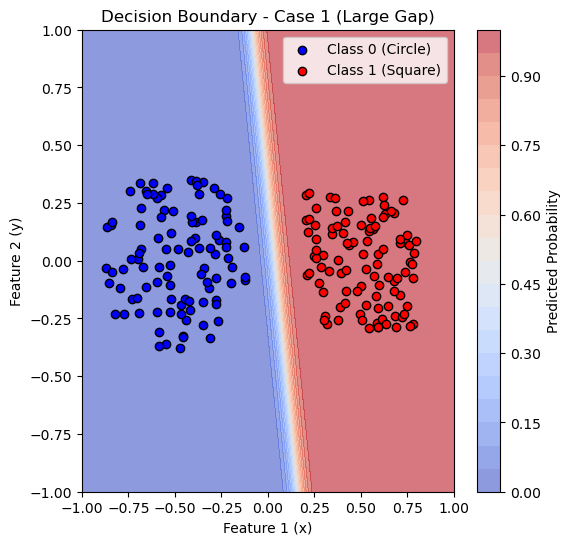

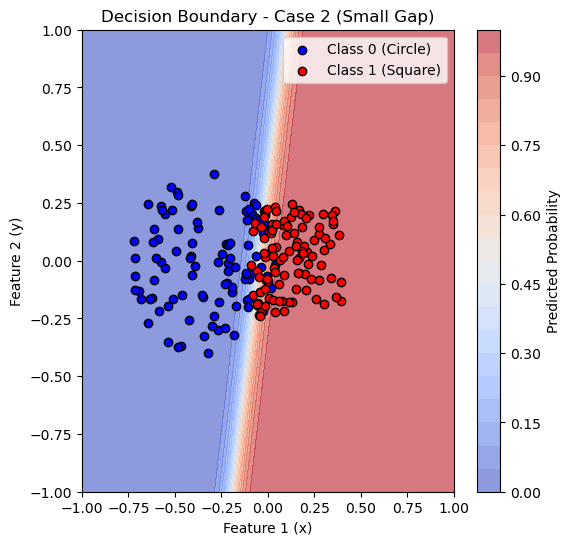

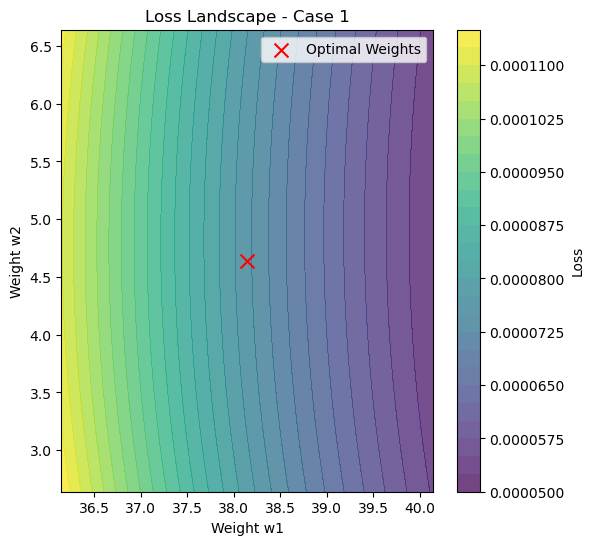

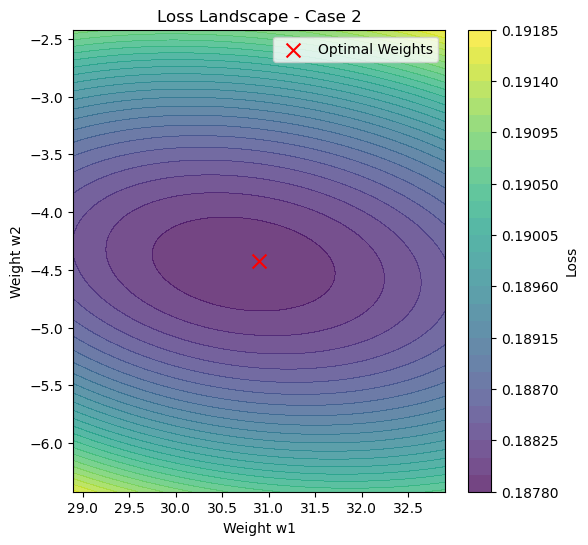

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# --- Generate Data: Circle vs. Square ---
def generate_data(circle_center, circle_radius, square_center, square_size, N):
    """Generates dataset where Class 0 is inside a circle and Class 1 is inside a square."""

    # Class 0: Inside a Circle
    theta = 2 * np.pi * np.random.rand(N)
    r = circle_radius * np.sqrt(np.random.rand(N))  # Random radius within circle
    x_circle = circle_center[0] + r * np.cos(theta)
    y_circle = circle_center[1] + r * np.sin(theta)
    class_0 = np.column_stack((x_circle, y_circle))

    # Class 1: Inside a Square
    x_square = square_center[0] + square_size * (np.random.rand(N) - 0.5)  
    y_square = square_center[1] + square_size * (np.random.rand(N) - 0.5)  
    class_1 = np.column_stack((x_square, y_square))

    # Merge datasets
    X_train = np.vstack((class_0, class_1))
    y_train = np.hstack((np.zeros(N), np.ones(N)))  # 0 for circle, 1 for square

    return X_train, y_train

# Define Two Cases
N = 100  # Number of points per class

# Case 1: Large separation (easier classification)
circle_center1, square_center1 = (-0.5, 0), (0.5, 0)
circle_radius1, square_size1 = 0.4, 0.6
X_train1, y_train1 = generate_data(circle_center1, circle_radius1, square_center1, square_size1, N)

# Case 2: Small separation (harder classification, but still separable)
circle_center2, square_center2 = (-0.35, 0), (0.15, 0)  # Closer together, but still separate
circle_radius2, square_size2 = 0.4, 0.5
X_train2, y_train2 = generate_data(circle_center2, circle_radius2, square_center2, square_size2, N)

# Convert to PyTorch tensors
X_train_tensor1 = torch.tensor(X_train1, dtype=torch.float32)
y_train_tensor1 = torch.tensor(y_train1, dtype=torch.float32).reshape(-1, 1)

X_train_tensor2 = torch.tensor(X_train2, dtype=torch.float32)
y_train_tensor2 = torch.tensor(y_train2, dtype=torch.float32).reshape(-1, 1)

# --- Logistic Regression Model ---
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(2, 1)  # Two input features (x, y)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoid activation

def train_model(X_train_tensor, y_train_tensor):
    """Trains logistic regression and returns trained model."""
    model = LogisticRegression()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.05)

    num_epochs = 1000  # More epochs to ensure convergence
    batch_size = 20
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

    w1, w2 = model.linear.weight.detach().numpy()[0]
    b = model.linear.bias.detach().numpy()[0]

    return model, w1, w2, b

# Train both cases
model1, w1_1, w2_1, b1 = train_model(X_train_tensor1, y_train_tensor1)
model2, w1_2, w2_2, b2 = train_model(X_train_tensor2, y_train_tensor2)

# --- Print Optimal Values ---
print(f"Case 1 (Large Gap): w1 = {w1_1:.4f}, w2 = {w2_1:.4f}, b = {b1:.4f}")
print(f"Case 2 (Small Gap): w1 = {w1_2:.4f}, w2 = {w2_2:.4f}, b = {b2:.4f}")

# --- Visualization: Decision Boundary ---
def plot_decision_boundary(X_train, y_train, model, title):
    """Plots dataset with predicted decision boundary."""
    xx, yy = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1, 1, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    Z = model(grid_tensor).detach().numpy().reshape(xx.shape)

    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, levels=20, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Predicted Probability")
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='blue', label="Class 0 (Circle)", edgecolors='k')
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='red', label="Class 1 (Square)", edgecolors='k')

    plt.xlabel("Feature 1 (x)")
    plt.ylabel("Feature 2 (y)")
    plt.legend()
    plt.title(title)
    plt.show()

# Plot both cases
plot_decision_boundary(X_train1, y_train1, model1, "Decision Boundary - Case 1 (Large Gap)")
plot_decision_boundary(X_train2, y_train2, model2, "Decision Boundary - Case 2 (Small Gap)")

# --- Visualization: Loss Landscape ---
def plot_loss_landscape(w1_opt, w2_opt, b_opt, X_train_tensor, y_train_tensor, title):
    """Plots loss landscape over (w1, w2)."""
    w1_range = np.linspace(w1_opt - 2, w1_opt + 2, 100)
    w2_range = np.linspace(w2_opt - 2, w2_opt + 2, 100)
    W1, W2 = np.meshgrid(w1_range, w2_range)
    Loss = np.zeros_like(W1)

    criterion = nn.BCELoss()

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            temp_model = LogisticRegression()
            temp_model.linear.weight.data = torch.tensor([[W1[i, j], W2[i, j]]], dtype=torch.float32)
            temp_model.linear.bias.data = torch.tensor([b_opt], dtype=torch.float32)
            predictions = temp_model(X_train_tensor)
            loss_value = criterion(predictions, y_train_tensor).item()
            Loss[i, j] = loss_value

    plt.figure(figsize=(6,6))
    plt.contourf(W1, W2, Loss, levels=30, cmap='viridis', alpha=0.75)
    plt.colorbar(label="Loss")
    plt.scatter(w1_opt, w2_opt, c='red', marker='x', s=100, label="Optimal Weights")
    plt.xlabel("Weight w1")
    plt.ylabel("Weight w2")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot both landscapes
plot_loss_landscape(w1_1, w2_1, b1, X_train_tensor1, y_train_tensor1, "Loss Landscape - Case 1")
plot_loss_landscape(w1_2, w2_2, b2, X_train_tensor2, y_train_tensor2, "Loss Landscape - Case 2")

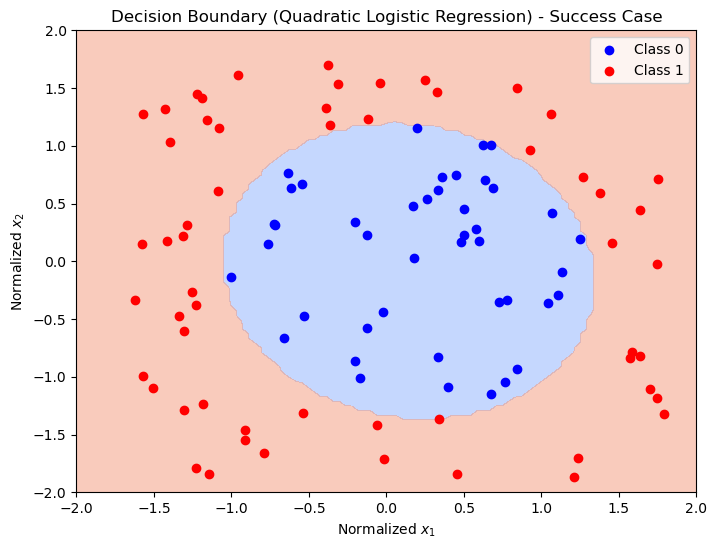

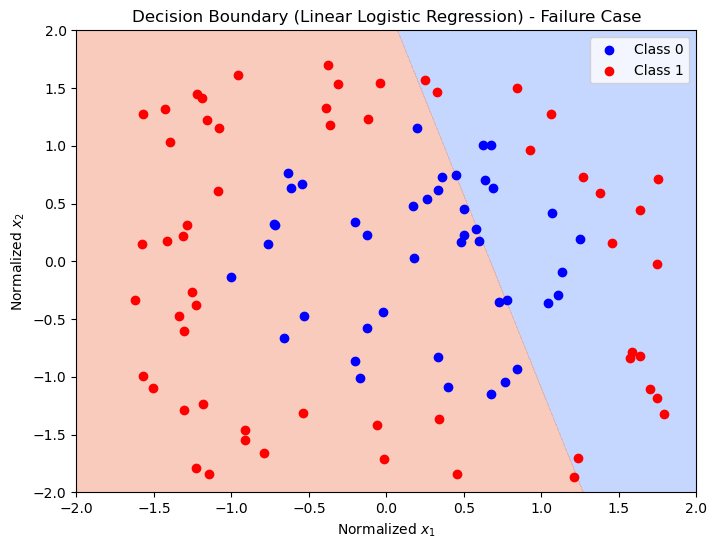

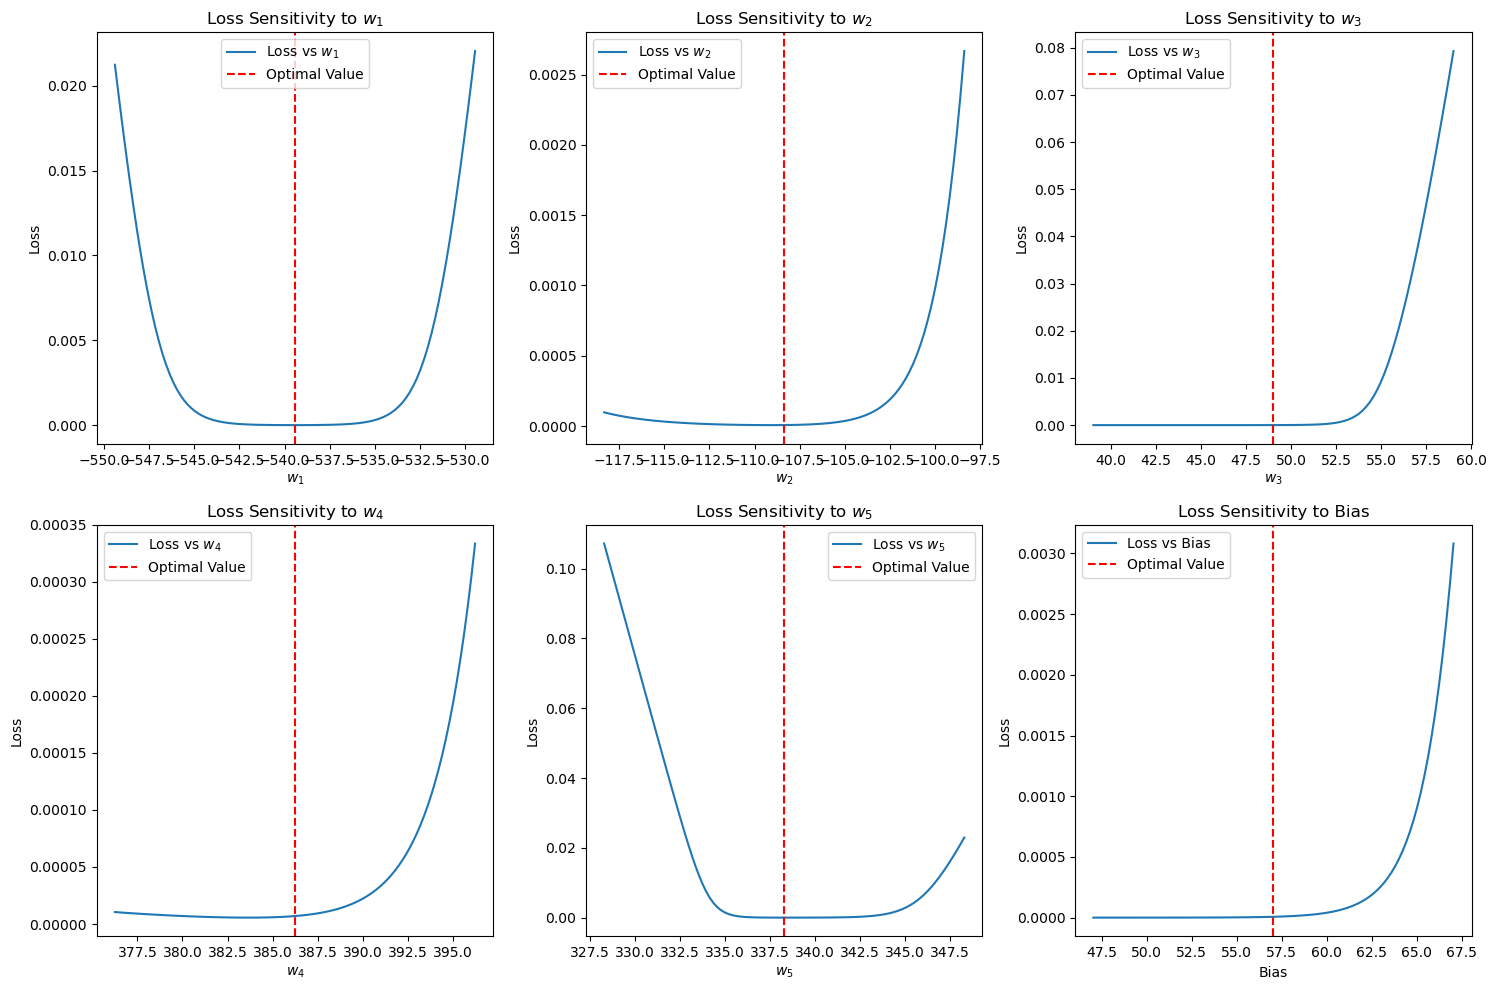

Optimal parameters (Linear Regression): [ 0.29674504 -0.44244714 -0.13256902]
Optimal parameters (Quadratic Regression): [-539.41836848 -108.35120863   49.02417916  386.24679329  338.28230487
   57.03024156]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

# Generate non-linearly separable synthetic data (interior vs. exterior of a circle)
np.random.seed(0)
N = 100  # Number of samples

x1 = np.random.uniform(-1, 1, N)
x2 = np.random.uniform(-1, 1, N)
labels = (x1**2 + x2**2 > 0.5).astype(int)  # Circle boundary

# Normalize input features
scaler = StandardScaler()
X_original = np.column_stack((x1, x2))
X_scaled = scaler.fit_transform(X_original)

# Linear feature set
X_linear = np.hstack((np.ones((N, 1)), X_scaled))  # Add bias term

# Quadratic feature set
x1_scaled, x2_scaled = X_scaled[:, 0], X_scaled[:, 1]
X_quad = np.column_stack((x1_scaled, x2_scaled, x1_scaled**2, x2_scaled**2, x1_scaled*x2_scaled))
X_quad = np.hstack((np.ones((N, 1)), X_quad))  # Add bias term

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cross-entropy loss function
def loss_function(w, X, y):
    z = np.dot(X, w)
    y_pred = sigmoid(z)
    return -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))  # Add epsilon to prevent log(0)

# Optimize logistic regression (linear)
w_init = np.zeros(X_linear.shape[1])
res_linear = minimize(loss_function, w_init, args=(X_linear, labels), method="BFGS")
w_opt_linear = res_linear.x  # Optimal weights for linear logistic regression

# Optimize logistic regression (quadratic)
w_init = np.zeros(X_quad.shape[1])
res_quad = minimize(loss_function, w_init, args=(X_quad, labels), method="BFGS")
w_opt_quad = res_quad.x  # Optimal weights for quadratic logistic regression

# Decision boundary visualization (quadratic logistic regression)
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
XX = np.column_stack((xx.ravel(), yy.ravel()))
XX_quad = np.column_stack((XX[:, 0], XX[:, 1], XX[:, 0]**2, XX[:, 1]**2, XX[:, 0]*XX[:, 1]))
XX_quad = np.hstack((np.ones((XX_quad.shape[0], 1)), XX_quad))  # Add bias term

Z_quad = sigmoid(np.dot(XX_quad, w_opt_quad)).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_quad, levels=[0, 0.5, 1], alpha=0.5, cmap="coolwarm")
plt.scatter(x1_scaled[labels == 0], x2_scaled[labels == 0], color="blue", label="Class 0")
plt.scatter(x1_scaled[labels == 1], x2_scaled[labels == 1], color="red", label="Class 1")
plt.xlabel("Normalized $x_1$")
plt.ylabel("Normalized $x_2$")
plt.legend()
plt.title("Decision Boundary (Quadratic Logistic Regression) - Success Case")
plt.show()

# Decision boundary visualization (linear logistic regression)
Z_linear = sigmoid(np.dot(np.hstack((np.ones((XX.shape[0], 1)), XX)), w_opt_linear)).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_linear, levels=[0, 0.5, 1], alpha=0.5, cmap="coolwarm")
plt.scatter(x1_scaled[labels == 0], x2_scaled[labels == 0], color="blue", label="Class 0")
plt.scatter(x1_scaled[labels == 1], x2_scaled[labels == 1], color="red", label="Class 1")
plt.xlabel("Normalized $x_1$")
plt.ylabel("Normalized $x_2$")
plt.legend()
plt.title("Decision Boundary (Linear Logistic Regression) - Failure Case")
plt.show()

# Sensitivity Analysis: Loss function dependence on each parameter (Quadratic Model)
vicinity_factor = 10  # Adjust this to control the range of parameter variation

params = ["$w_1$", "$w_2$", "$w_3$", "$w_4$", "$w_5$", "Bias"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(len(w_opt_quad)):
    param_range = np.linspace(w_opt_quad[i] - vicinity_factor, w_opt_quad[i] + vicinity_factor, 100)  # Scalable range
    losses = []

    for val in param_range:
        w_temp = w_opt_quad.copy()
        w_temp[i] = val
        losses.append(loss_function(w_temp, X_quad, labels))

    ax = axes[i // 3, i % 3]
    ax.plot(param_range, losses, label=f"Loss vs {params[i]}")
    ax.axvline(w_opt_quad[i], color='r', linestyle='--', label="Optimal Value")
    ax.set_xlabel(params[i])
    ax.set_ylabel("Loss")
    ax.legend()
    ax.set_title(f"Loss Sensitivity to {params[i]}")

plt.tight_layout()
plt.show()

# Display optimal parameters for both models
print("Optimal parameters (Linear Regression):", w_opt_linear)
print("Optimal parameters (Quadratic Regression):", w_opt_quad)

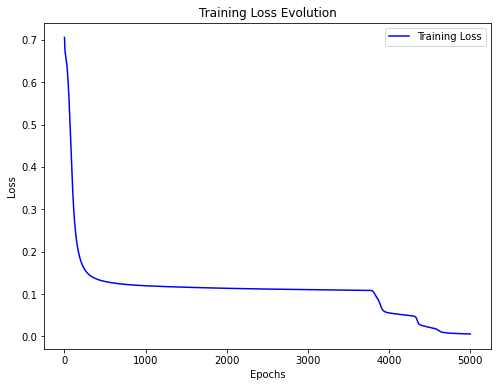

Trained weights: w1 = -4.863, w2 = -0.365
Trained bias: b = 1.863


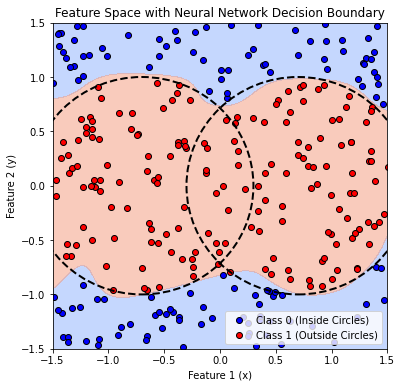

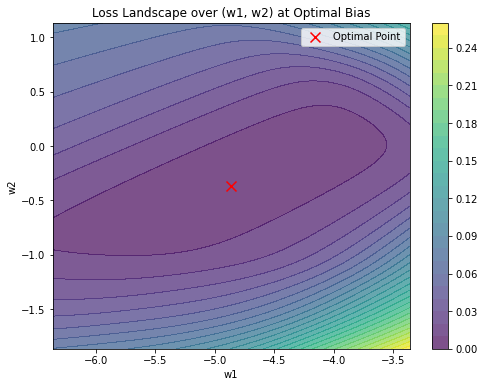

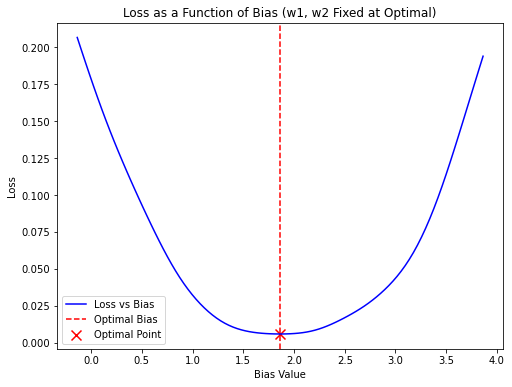

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==== ADJUSTABLE PARAMETERS ====
center1 = (-0.7, 0)  # Center of first circle
center2 = (0.7, 0)   # Center of second circle
radius1 = 1.0        # Radius of first circle
radius2 = 1.0        # Radius of second circle
num_samples = 300    # Number of training points
noise_std = 0.01      # Standard deviation of noise (adjustable)

# ==== GENERATE DATASET ====
np.random.seed(42)
x_train = np.random.uniform(-1.5, 1.5, (num_samples, 2))  # Generate random points
y_train = np.logical_or(
    (x_train[:, 0] - center1[0])**2 + (x_train[:, 1] - center1[1])**2 < radius1**2,
    (x_train[:, 0] - center2[0])**2 + (x_train[:, 1] - center2[1])**2 < radius2**2
).astype(int)  # Assign label 0 inside circles, 1 outside

# Add noise to the dataset
x_train += np.random.normal(0, noise_std, x_train.shape)

# Convert to tensors
X_train = torch.tensor(x_train, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# ==== DEFINE A SIMPLE SINGLE-LAYER NEURAL NETWORK ====
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(2, 10)  # 10 neurons in hidden layer
        self.output = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.hidden(x))  # Use tanh activation
        x = torch.sigmoid(self.output(x))  # Sigmoid for binary classification
        return x

# Instantiate model, loss function, and optimizer
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ==== TRAIN THE NETWORK ====
epochs = 5000
loss_history = []  # Store loss values

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, Y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())  # Store loss per epoch

# ==== PLOT TRAINING LOSS CURVE ====
plt.figure(figsize=(8, 6))
plt.plot(loss_history, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Evolution")
plt.show()

# Extract trained weights from the first hidden layer (we visualize the first neuron)
trained_weights = model.hidden.weight.detach().numpy()
trained_bias = model.hidden.bias.detach().numpy()

# ** Selecting the first neuron for visualization **
w1_opt, w2_opt = trained_weights[0, 0], trained_weights[0, 1]  # First neuron's weights
b_opt = trained_bias[0]  # First neuron's bias

print(f"Trained weights: w1 = {w1_opt:.3f}, w2 = {w2_opt:.3f}")
print(f"Trained bias: b = {b_opt:.3f}")

# ==== PLOT FEATURE SPACE WITH DECISION BOUNDARY ====
fig, ax = plt.subplots(figsize=(6, 6))

# Generate test grid
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# Get model predictions
with torch.no_grad():
    predictions = model(grid_tensor).numpy().reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, predictions, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.5)

# Plot original training points
plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], color='blue', edgecolors='k', label="Class 0 (Inside Circles)")
plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], color='red', edgecolors='k', label="Class 1 (Outside Circles)")

# Overlay the ground truth circles
circle1 = plt.Circle(center1, radius1, color='black', fill=False, linestyle='dashed', linewidth=2)
circle2 = plt.Circle(center2, radius2, color='black', fill=False, linestyle='dashed', linewidth=2)
ax.add_patch(circle1)
ax.add_patch(circle2)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Feature 1 (x)")
plt.ylabel("Feature 2 (y)")
plt.legend()
plt.title("Feature Space with Neural Network Decision Boundary")
plt.show()

# ==== PLOT LOSS LANDSCAPE OVER (w1, w2) AT OPTIMAL BIAS ====
w1_range = np.linspace(w1_opt - 1.5, w1_opt + 1.5, 100)
w2_range = np.linspace(w2_opt - 1.5, w2_opt + 1.5, 100)
W1, W2 = np.meshgrid(w1_range, w2_range)

loss_values = np.zeros_like(W1)

for j in range(W1.shape[0]):
    for k in range(W1.shape[1]):
        with torch.no_grad():
            model.hidden.weight.data[0, 0] = torch.tensor(W1[j, k])
            model.hidden.weight.data[0, 1] = torch.tensor(W2[j, k])
            model.hidden.bias.data[0] = torch.tensor(b_opt)
            y_pred = model(X_train)
            loss_values[j, k] = criterion(y_pred, Y_train).item()

plt.figure(figsize=(8, 6))
cp = plt.contourf(W1, W2, loss_values, levels=30, cmap='viridis', alpha=0.7)
plt.colorbar(cp)
plt.scatter([w1_opt], [w2_opt], color='red', marker='x', s=100, label="Optimal Point")
plt.xlabel("w1")
plt.ylabel("w2")
plt.legend()
plt.title("Loss Landscape over (w1, w2) at Optimal Bias")
plt.show()

# ==== PLOT LOSS AS FUNCTION OF BIAS ====
bias_range = np.linspace(b_opt - 2, b_opt + 2, 100)
loss_bias = []

for b in bias_range:
    with torch.no_grad():
        model.hidden.bias.data[0] = torch.tensor(b)
        model.hidden.weight.data[0, 0] = torch.tensor(w1_opt)  # Keep w1 fixed
        model.hidden.weight.data[0, 1] = torch.tensor(w2_opt)  # Keep w2 fixed
        y_pred = model(X_train)
        loss_bias.append(criterion(y_pred, Y_train).item())

plt.figure(figsize=(8, 6))
plt.plot(bias_range, loss_bias, label="Loss vs Bias", color="blue")
plt.axvline(b_opt, color="red", linestyle="--", label="Optimal Bias")
plt.scatter([b_opt], [min(loss_bias)], color='red', marker='x', s=100, label="Optimal Point")
plt.xlabel("Bias Value")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss as a Function of Bias (w1, w2 Fixed at Optimal)")
plt.show()